#### Imports <a name="imports"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process

/Users/merelkamper/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#### Data Loading <a name="data-loading"></a>

In [2]:
# Load data from path
folder_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/train_rides'
files = os.listdir(folder_path)
dfs=[]

for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

# Combine different files                
all_train_services = pd.concat(dfs, ignore_index=True)

In [317]:
all_train_services

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled
0,738804,2019-01-01,Intercity,NS,1410,False,False,1,6220112,RTD,Rotterdam Centraal,NaN,NaN,NaN,2019-01-01T02:00:00+01:00,1.0,False
1,738804,2019-01-01,Intercity,NS,1410,False,False,0,6220116,DT,Delft,2019-01-01T02:12:00+01:00,0.0,False,2019-01-01T02:12:00+01:00,0.0,False
2,738804,2019-01-01,Intercity,NS,1410,False,False,0,6220120,GV,Den Haag HS,2019-01-01T02:20:00+01:00,1.0,False,2019-01-01T02:21:00+01:00,1.0,False
3,738804,2019-01-01,Intercity,NS,1410,False,False,0,6220124,LEDN,Leiden Centraal,2019-01-01T02:35:00+01:00,0.0,False,2019-01-01T02:45:00+01:00,0.0,False
4,738804,2019-01-01,Intercity,NS,1410,False,False,0,6220128,SHL,Schiphol Airport,2019-01-01T03:00:00+01:00,0.0,False,2019-01-01T03:02:00+01:00,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115266899,13090236,2024-02-29,Intercity,NS,300786,False,True,0,118020655,ASDZ,Amsterdam Zuid,2024-03-01T00:47:00+01:00,8.0,False,2024-03-01T00:48:00+01:00,9.0,False
115266900,13090236,2024-02-29,Intercity,NS,300786,False,True,0,118020656,SHL,Schiphol Airport,2024-03-01T00:54:00+01:00,9.0,False,2024-03-01T00:56:00+01:00,8.0,False
115266901,13090236,2024-02-29,Intercity,NS,300786,False,True,0,118020657,LEDN,Leiden Centraal,2024-03-01T01:11:00+01:00,8.0,False,NaN,NaN,NaN
115266902,13092579,2024-02-29,Extra trein,NS,29291,False,False,0,118031884,MP,Meppel,NaN,NaN,NaN,2024-03-01T00:10:00+01:00,0.0,False


#### Data Cleaning <a name="data-cleaning"></a>

In [3]:
# Filter on NS and train data (no replacement transportations or buses etc.)
ns_data = all_train_services[all_train_services['Service:Company'].str.lower().str.contains('ns')]
ns_train_data = ns_data[ns_data['Service:Type'].isin(['Intercity', 'Sprinter', 'Intercity direct', 'Eurostar', 'Thalys', 'Extra trein', 
                                                      'ICE International', 'Int. Trein', 'Speciale Trein', 'Nightjet'])]

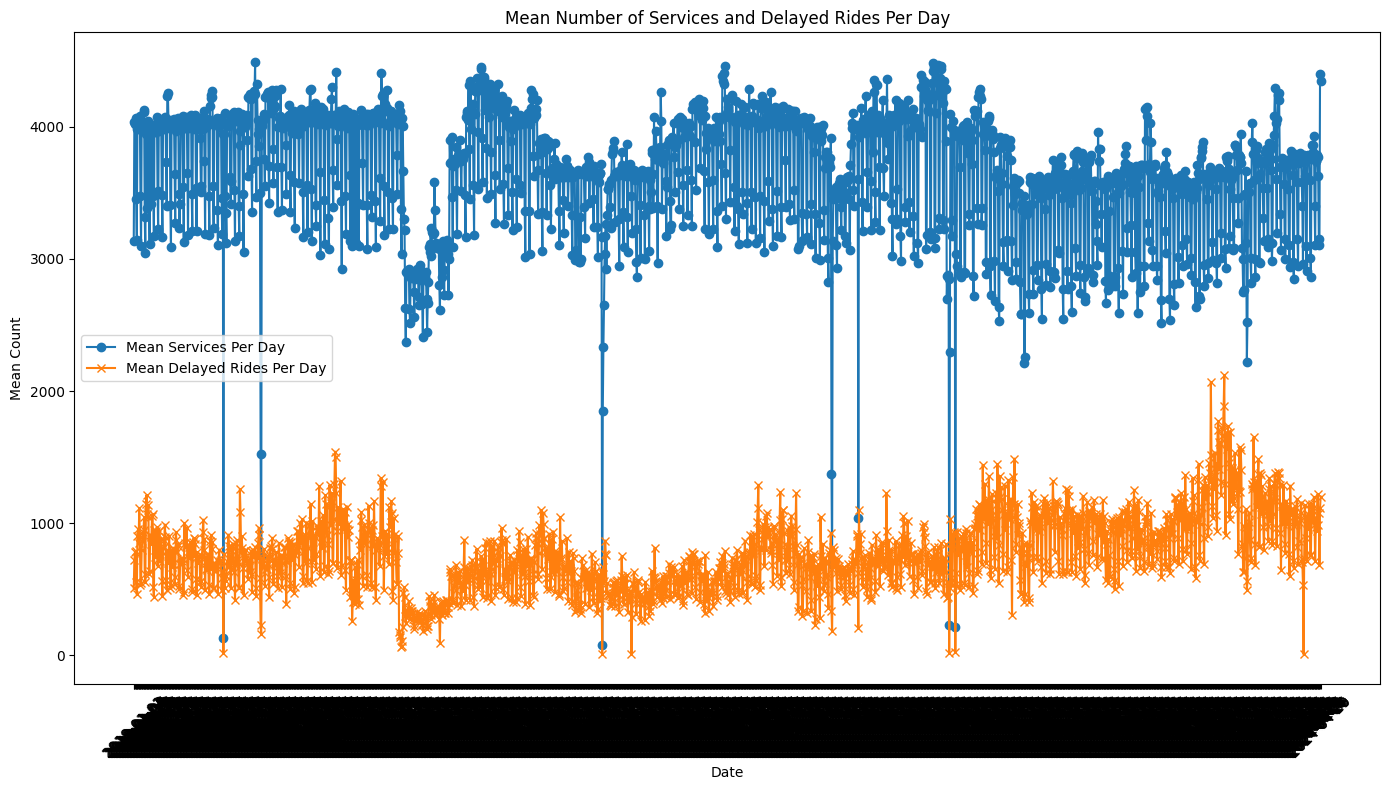

In [7]:
# Filter out completely cancelled services
df_filtered = ns_train_data[~ns_train_data['Service:Completely cancelled']]

# Sort the data by Service:RDT-ID and the order of the stops to ensure the last stop is at the end
df_sorted = df_filtered.sort_values(by=['Service:RDT-ID'])

# Extract the last stop for each service
last_stops = df_sorted.drop_duplicates(subset=['Service:RDT-ID'], keep='last')

# Group by Service:Date to get the number of services per day
services_per_day = last_stops.groupby('Service:Date').size().reset_index(name='Service Count')

# Calculate the mean number of services per day
mean_services_per_day = services_per_day.groupby('Service:Date')['Service Count'].mean().reset_index(name='Mean Services Per Day')

# Filter for rides with an arrival delay of more than 0 and not NaN in the last stop
delayed_last_stops = last_stops[last_stops['Stop:Arrival delay'] > 0].dropna(subset=['Stop:Arrival delay'])

# Group by Service:Date to get the number of delayed services per day
delayed_rides_per_day = delayed_last_stops.groupby('Service:Date').size().reset_index(name='Delayed Ride Count')

# Calculate the mean number of delayed rides per day
mean_delayed_rides_per_day = delayed_rides_per_day.groupby('Service:Date')['Delayed Ride Count'].mean().reset_index(name='Mean Delayed Rides Per Day')

# Merge the two dataframes on Service:Date
merged_df = pd.merge(mean_services_per_day, mean_delayed_rides_per_day, on='Service:Date', how='left')

# Plotting the data
plt.figure(figsize=(14, 8))

# Plot Mean Services Per Day
plt.plot(merged_df['Service:Date'], merged_df['Mean Services Per Day'], label='Mean Services Per Day', marker='o')

# Plot Mean Delayed Rides Per Day
plt.plot(merged_df['Service:Date'], merged_df['Mean Delayed Rides Per Day'], label='Mean Delayed Rides Per Day', marker='x')

# Formatting the plot
plt.title('Mean Number of Services and Delayed Rides Per Day')
plt.xlabel('Date')
plt.ylabel('Mean Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [4]:
ns_train_data.to_csv("ns_data.csv")

In [319]:
ns_train_data

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled
0,738804,2019-01-01,Intercity,NS,1410,False,False,1,6220112,RTD,Rotterdam Centraal,NaN,NaN,NaN,2019-01-01T02:00:00+01:00,1.0,False
1,738804,2019-01-01,Intercity,NS,1410,False,False,0,6220116,DT,Delft,2019-01-01T02:12:00+01:00,0.0,False,2019-01-01T02:12:00+01:00,0.0,False
2,738804,2019-01-01,Intercity,NS,1410,False,False,0,6220120,GV,Den Haag HS,2019-01-01T02:20:00+01:00,1.0,False,2019-01-01T02:21:00+01:00,1.0,False
3,738804,2019-01-01,Intercity,NS,1410,False,False,0,6220124,LEDN,Leiden Centraal,2019-01-01T02:35:00+01:00,0.0,False,2019-01-01T02:45:00+01:00,0.0,False
4,738804,2019-01-01,Intercity,NS,1410,False,False,0,6220128,SHL,Schiphol Airport,2019-01-01T03:00:00+01:00,0.0,False,2019-01-01T03:02:00+01:00,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115266899,13090236,2024-02-29,Intercity,NS,300786,False,True,0,118020655,ASDZ,Amsterdam Zuid,2024-03-01T00:47:00+01:00,8.0,False,2024-03-01T00:48:00+01:00,9.0,False
115266900,13090236,2024-02-29,Intercity,NS,300786,False,True,0,118020656,SHL,Schiphol Airport,2024-03-01T00:54:00+01:00,9.0,False,2024-03-01T00:56:00+01:00,8.0,False
115266901,13090236,2024-02-29,Intercity,NS,300786,False,True,0,118020657,LEDN,Leiden Centraal,2024-03-01T01:11:00+01:00,8.0,False,NaN,NaN,NaN
115266902,13092579,2024-02-29,Extra trein,NS,29291,False,False,0,118031884,MP,Meppel,NaN,NaN,NaN,2024-03-01T00:10:00+01:00,0.0,False


#### Data Tranformation <a name="data-transformation"></a>

We will use the grouped data to aggregate information for each trajectory.

In [320]:
grouped = ns_train_data.groupby('Service:RDT-ID')

rdt_ids = grouped['Service:RDT-ID'].unique()
trajectories = ns_train_data.groupby('Service:RDT-ID')['Stop:Station name'].agg(['first', 'last']).agg(' - '.join, axis=1)
dates = grouped['Service:Date'].first()
day_of_week = pd.to_datetime(dates).dt.day_name()
max_delays = grouped['Service:Maximum delay'].first()
arrival_delays_last_stop = grouped['Stop:Arrival delay'].last()
planned_stops = np.maximum(grouped.size() - 2, 0)  # Subtract 2 for departure and arrival stops
cancelled_arrivals = grouped['Stop:Arrival cancelled'].sum()
cancelled_departures = grouped['Stop:Departure cancelled'].sum()
delayed_arrivals = (ns_train_data['Stop:Arrival delay'] > 0).groupby(ns_train_data['Service:RDT-ID']).sum()
delayed_departures = (ns_train_data['Stop:Departure delay'] > 0).groupby(ns_train_data['Service:RDT-ID']).sum()
partly_cancelled = grouped['Service:Partly cancelled'].any()
completely_cancelled = grouped['Service:Completely cancelled'].all()
last_stop_cancelled = grouped.last()['Stop:Arrival cancelled']

definite_df = pd.DataFrame({
    'RDT-ID': rdt_ids,
    'Trajectory': trajectories,
    'Date': dates,
    'Day of the Week': day_of_week,
    'Maximum Delay': max_delays,
    'Arrival Delay of Last Stop (min)': arrival_delays_last_stop,
    'Nr. of Planned Stops': planned_stops,
    'Nr. of Cancelled Arrivals': cancelled_arrivals,
    'Nr. of Cancelled Departures': cancelled_departures,
    'Nr. of Delayed Arrivals': delayed_arrivals,
    'Nr. of Delayed Departures': delayed_departures,
    'Partly Cancelled': partly_cancelled,
    'Completely Cancelled': completely_cancelled,
    'Last Arrival Cancelled': last_stop_cancelled
})

definite_df['Date'] = pd.to_datetime(definite_df['Date'])

In [321]:
# Handling of the 250 NaN values in "Arrival Delay of Last Stop (min)"" and None values in "Last Arrival Cancelled"
# Set 'Arrival Delay of Last Stop (min)' to 0 or another placeholder for unfinished trajectories
definite_df['Arrival Delay of Last Stop (min)'].fillna(-1, inplace=True)

# Set 'Last Arrival Cancelled' to True for these cases as they represent cancellations
definite_df['Last Arrival Cancelled'].fillna(True, inplace=True)

In [322]:
definite_df

,RDT-ID,Trajectory,Date,Day of the Week,Maximum Delay,Arrival Delay of Last Stop (min),Nr. of Planned Stops,Nr. of Cancelled Arrivals,Nr. of Cancelled Departures,Nr. of Delayed Arrivals,Nr. of Delayed Departures,Partly Cancelled,Completely Cancelled,Last Arrival Cancelled
Service:RDT-ID,,,,,,,,,,,,,,
738804,[738804],Rotterdam Centraal - Utrecht Centraal,2019-01-01,Tuesday,1,0.0,5,0,0,2,2,False,False,False
738805,[738805],Utrecht Centraal - Rotterdam Centraal,2019-01-01,Tuesday,2,0.0,6,0,0,2,1,False,False,False
738806,[738806],Rotterdam Centraal - Utrecht Centraal,2019-01-01,Tuesday,2,0.0,5,0,0,2,2,False,False,False
738807,[738807],Utrecht Centraal - Rotterdam Centraal,2019-01-01,Tuesday,2,2.0,5,0,0,2,0,False,False,False
738808,[738808],Rotterdam Centraal - Utrecht Centraal,2019-01-01,Tuesday,1,0.0,5,0,0,0,2,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13487668,[13487668],Den Haag Centraal - 's-Hertogenbosch,2024-04-30,Tuesday,2,2.0,19,4,4,6,6,True,False,False
13487909,[13487909],Hoofddorp - Hoorn,2024-04-30,Tuesday,0,0.0,8,8,8,0,0,True,False,False
13487958,[13487958],Dordrecht - Venlo,2024-04-30,Tuesday,1,0.0,17,13,13,2,3,True,False,False


In [323]:
definite_df.to_csv("ALL_TRAJ.csv", index=False)

In [324]:
definite_df['Date'] = pd.to_datetime(definite_df['Date'])

definite_df[['ORIGIN', 'DESTINATION']] = definite_df['Trajectory'].str.split(' - ', expand=True)

definite_df['ORIGIN'] = definite_df['ORIGIN'].replace({'Amersfoort': 'Amersfoort Centraal', 'Eindhoven': 'Eindhoven Centraal'})
definite_df['DESTINATION'] = definite_df['DESTINATION'].replace({'Amersfoort': 'Amersfoort Centraal', 'Eindhoven': 'Eindhoven Centraal'})

rides_performed = definite_df.dropna(subset=['Arrival Delay of Last Stop (min)']).groupby(['Date','ORIGIN', 'DESTINATION']).size().reset_index(name='Rides planned')
delayed_arrivals = definite_df[definite_df['Arrival Delay of Last Stop (min)'] > 0.0].groupby(['Date', 'ORIGIN', 'DESTINATION']).size().reset_index(name='Final arrival delay')
arrival_canceled = definite_df.groupby(['Date', 'ORIGIN', 'DESTINATION'])['Last Arrival Cancelled'].sum().reset_index(name='Final arrival cancelled')
trajectory_canceled = definite_df.groupby(['Date', 'ORIGIN', 'DESTINATION'])['Completely Cancelled'].sum().reset_index(name='Completely cancelled')
intermediate_delays = definite_df[definite_df['Nr. of Delayed Arrivals'] > 0].groupby(['Date', 'ORIGIN', 'DESTINATION']).size().reset_index(name='Intermediate arrival delays')

trajectories_per_day = rides_performed.merge(delayed_arrivals, on=['Date', 'ORIGIN', 'DESTINATION'], how='left')
trajectories_per_day = trajectories_per_day.merge(arrival_canceled, on=['Date', 'ORIGIN', 'DESTINATION'], how='left')
trajectories_per_day = trajectories_per_day.merge(trajectory_canceled, on=['Date', 'ORIGIN', 'DESTINATION'], how='left')
trajectories_per_day = trajectories_per_day.merge(intermediate_delays, on=['Date', 'ORIGIN', 'DESTINATION'], how='left')

trajectories_per_day['Final arrival delay'].fillna(0, inplace=True)
trajectories_per_day['Final arrival delay'] = trajectories_per_day['Final arrival delay'].astype(int)
trajectories_per_day['Final arrival cancelled'] = trajectories_per_day['Final arrival cancelled'].replace(False, 0).astype(int)
trajectories_per_day['Intermediate arrival delays'] = trajectories_per_day['Intermediate arrival delays'].fillna(0).astype(int)

# Remove rows where ORIGIN is the same as DESTINATION
trajectories_per_day = trajectories_per_day[trajectories_per_day['ORIGIN'] != trajectories_per_day['DESTINATION']]

In [326]:
# Add a 'Trajectory' column by concatenating 'ORIGIN' and 'DESTINATION'
trajectories_per_day['Trajectory'] = trajectories_per_day['ORIGIN'] + " - " + trajectories_per_day['DESTINATION']

# Function to get top trajectories for a given year
def get_top_trajectories(data, year):
    data_year = data[data['Date'].dt.year == year]
    top_trajectories = data_year.groupby('Trajectory')['Rides planned'].sum().reset_index()
    top_trajectories = top_trajectories.sort_values(by='Rides planned', ascending=False)
    top_trajectories.columns = ['Trajectory', f'Count_{year}']
    return top_trajectories

# Function to calculate MAD
def calculate_mad(data):
    median = np.median(data)
    abs_deviation = np.abs(data - median)
    mad = np.median(abs_deviation)
    return mad

# Define a function to apply filtering based on MAD
def filter_based_on_mad(data, year):
    counts = data[f'Count_{year}'].values
    median = np.median(counts)
    mad = calculate_mad(counts)
    lower_bound = median - mad
    filtered_data = data[data[f'Count_{year}'] > mad]
    return filtered_data, median, mad, lower_bound 

# Get top trajectories for every year
top_trajectories_2019 = get_top_trajectories(trajectories_per_day, 2019)
top_trajectories_2020 = get_top_trajectories(trajectories_per_day, 2020)
top_trajectories_2021 = get_top_trajectories(trajectories_per_day, 2021)
top_trajectories_2022 = get_top_trajectories(trajectories_per_day, 2022)
top_trajectories_2023 = get_top_trajectories(trajectories_per_day, 2023)
top_trajectories_2024 = get_top_trajectories(trajectories_per_day, 2024)

filtered_trajectories_2019, median_2019, mad_2019, lower_bound_2019 = filter_based_on_mad(top_trajectories_2019, 2019)
filtered_trajectories_2020, median_2020, mad_2020, lower_bound_2020 = filter_based_on_mad(top_trajectories_2020, 2020)
filtered_trajectories_2021, median_2021, mad_2021, lower_bound_2021 = filter_based_on_mad(top_trajectories_2021, 2021)
filtered_trajectories_2022, median_2022, mad_2022, lower_bound_2022 = filter_based_on_mad(top_trajectories_2022, 2022)
filtered_trajectories_2023, median_2023, mad_2023, lower_bound_2023 = filter_based_on_mad(top_trajectories_2023, 2023)
filtered_trajectories_2024, median_2024, mad_2024, lower_bound_2024 = filter_based_on_mad(top_trajectories_2024, 2024)

In [327]:
# Filtered trajectories for each year
filtered_trajectories = {
    2019: filtered_trajectories_2019,
    2020: filtered_trajectories_2020,
    2021: filtered_trajectories_2021,
    2022: filtered_trajectories_2022,
    2023: filtered_trajectories_2023,
    2024: filtered_trajectories_2024}

filtered_trajectories_per_day = pd.DataFrame()

# Loop through each year and filter the data
for year in filtered_trajectories.keys():
    filtered_traj_for_year = filtered_trajectories[year]
    data_for_year = trajectories_per_day[trajectories_per_day['Date'].dt.year == year]
    filtered_data_for_year = data_for_year[data_for_year['Trajectory'].isin(filtered_traj_for_year['Trajectory'])]
    filtered_trajectories_per_day = pd.concat([filtered_trajectories_per_day, filtered_data_for_year], ignore_index=True)

In [328]:
filtered_trajectories_per_day

,Date,ORIGIN,DESTINATION,Rides planned,Final arrival delay,Final arrival cancelled,Completely cancelled,Intermediate arrival delays,Trajectory
0,2019-01-01,'s-Hertogenbosch,Arnhem Centraal,1,0,0,0,1,'s-Hertogenbosch - Arnhem Centraal
1,2019-01-01,'s-Hertogenbosch,Den Haag Centraal,33,4,2,0,27,'s-Hertogenbosch - Den Haag Centraal
2,2019-01-01,'s-Hertogenbosch,Deurne,17,4,1,0,11,'s-Hertogenbosch - Deurne
3,2019-01-01,'s-Hertogenbosch,Dordrecht,11,0,0,0,3,'s-Hertogenbosch - Dordrecht
4,2019-01-01,'s-Hertogenbosch,Eindhoven Centraal,18,2,0,0,7,'s-Hertogenbosch - Eindhoven Centraal
...,...,...,...,...,...,...,...,...,...
546869,2024-04-30,Wijchen,Zutphen,25,11,1,1,21,Wijchen - Zutphen
546870,2024-04-30,Zandvoort aan Zee,Haarlem,38,5,0,0,38,Zandvoort aan Zee - Haarlem
546871,2024-04-30,Zutphen,Nijmegen,9,5,1,0,7,Zutphen - Nijmegen
546872,2024-04-30,Zutphen,Wijchen,24,3,3,0,10,Zutphen - Wijchen


In [ ]:
filtered_trajectories_per_day.to_csv("trajectories_per_day.csv", index=False)

#### Filter outliers

In [ ]:
# Add a 'Trajectory' column by concatenating 'ORIGIN' and 'DESTINATION'
trajectories_per_day['Trajectory'] = trajectories_per_day['ORIGIN'] + " - " + trajectories_per_day['DESTINATION']

# Function to get top trajectories for a given year
def get_top_trajectories(data, year):
    data_year = data[data['Date'].dt.year == year]
    top_trajectories = data_year.groupby('Trajectory')['Rides planned'].sum().reset_index()
    top_trajectories = top_trajectories.sort_values(by='Rides planned', ascending=False)    
    top_trajectories.columns = ['Trajectory', f'Count_{year}']
    return top_trajectories

# Get top trajectories for each year from 2019 to 2023
years = range(2019, 2025)
top_trajectories_list = [get_top_trajectories(trajectories_per_day, year) for year in years]

# Merge all the top trajectories into a single DataFrame
top_trajectories_df = top_trajectories_list[0]
for top_trajectories in top_trajectories_list[1:]:
    top_trajectories_df = top_trajectories_df.merge(top_trajectories, on='Trajectory', how='outer')

# Fill NaN values with 0 (if any trajectories don't appear in some years)
top_trajectories_df = top_trajectories_df.fillna(0)

# Display the table
top_trajectories_df

,Trajectory,Count_2019,Count_2020,Count_2021,Count_2022,Count_2023,Count_2024
0,Amsterdam Centraal - Den Haag Centraal,24834.0,23785.0,24089.0,11892.0,5218.0,4680.0
1,Den Haag Centraal - Amsterdam Centraal,24546.0,23467.0,23602.0,11514.0,5201.0,4660.0
2,Den Haag Centraal - Dordrecht,21735.0,20577.0,21640.0,21104.0,19123.0,6498.0
3,Dordrecht - Den Haag Centraal,21627.0,20459.0,21533.0,21066.0,19074.0,6428.0
4,Rotterdam Centraal - Amsterdam Centraal,15845.0,11853.0,8444.0,9542.0,20741.0,4112.0
...,...,...,...,...,...,...,...
3720,Purmerend Overwhere - Amsterdam Bijlmer ArenA,0.0,0.0,0.0,0.0,0.0,1.0
3721,Nijverdal - Enschede,0.0,0.0,0.0,0.0,0.0,1.0
3722,Nijmegen - Haarlem,0.0,0.0,0.0,0.0,0.0,1.0
3723,Amsterdam Muiderpoort - Deventer,0.0,0.0,0.0,0.0,0.0,1.0


In [313]:
# Add a 'Trajectory' column by concatenating 'ORIGIN' and 'DESTINATION'
trajectories_per_day['Trajectory'] = trajectories_per_day['ORIGIN'] + " - " + trajectories_per_day['DESTINATION']

# Function to get top trajectories for a given year
def get_top_trajectories(data, year):
    data_year = data[data['Date'].dt.year == year]
    top_trajectories = data_year.groupby('Trajectory')['Rides planned'].sum().reset_index()
    top_trajectories = top_trajectories.sort_values(by='Rides planned', ascending=False)
    top_trajectories.columns = ['Trajectory', f'Count_{year}']
    return top_trajectories

# Function to calculate MAD
def calculate_mad(data):
    median = np.median(data)
    abs_deviation = np.abs(data - median)
    mad = np.median(abs_deviation)
    return mad

# Define a function to apply filtering based on MAD
def filter_based_on_mad(data, year):
    counts = data[f'Count_{year}'].values
    median = np.median(counts)
    mad = calculate_mad(counts)
    lower_bound = median - mad
    filtered_data = data[data[f'Count_{year}'] > mad]
    return filtered_data, median, mad, lower_bound 

# Get top trajectories for every year
top_trajectories_2019 = get_top_trajectories(trajectories_per_day, 2019)
top_trajectories_2020 = get_top_trajectories(trajectories_per_day, 2020)
top_trajectories_2021 = get_top_trajectories(trajectories_per_day, 2021)
top_trajectories_2022 = get_top_trajectories(trajectories_per_day, 2022)
top_trajectories_2023 = get_top_trajectories(trajectories_per_day, 2023)
top_trajectories_2024 = get_top_trajectories(trajectories_per_day, 2024)

filtered_trajectories_2019, median_2019, mad_2019, lower_bound_2019 = filter_based_on_mad(top_trajectories_2019, 2019)
filtered_trajectories_2020, median_2020, mad_2020, lower_bound_2020 = filter_based_on_mad(top_trajectories_2020, 2020)
filtered_trajectories_2021, median_2021, mad_2021, lower_bound_2021 = filter_based_on_mad(top_trajectories_2021, 2021)
filtered_trajectories_2022, median_2022, mad_2022, lower_bound_2022 = filter_based_on_mad(top_trajectories_2022, 2022)
filtered_trajectories_2023, median_2023, mad_2023, lower_bound_2023 = filter_based_on_mad(top_trajectories_2023, 2023)
filtered_trajectories_2024, median_2024, mad_2024, lower_bound_2024 = filter_based_on_mad(top_trajectories_2024, 2024)

#### Adding Extra Datasets <a name="adding-extra-datasets"></a>

##### Station distances 

First we will create a **distance overview** from every station to every station based on the matrix from: https://www.rijdendetreinen.nl/en/open-data/station-distances.

In [15]:
# STEP 1: Get distances for codes
matrix_df = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/Files from internet/distances_ns_international.csv', index_col=0)

origin_codes = []
destination_codes = []
distances = []

for origin_code in matrix_df.index:
    for destination_code in matrix_df.columns:
        distance = matrix_df.loc[origin_code, destination_code]
        if distance != 'XXX' and distance != '?': 
            origin_codes.append(origin_code)
            destination_codes.append(destination_code)
            distances.append(distance)

new_df = pd.DataFrame({
    'origin_code': origin_codes,
    'destination_code': destination_codes,
    'distance': distances
})

# STEP 2: Let's change the codes to names
path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/Stations info'
files = os.listdir(path)
dfs=[]
for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)
station_df = pd.concat(dfs, ignore_index=True)

code_to_name = dict(zip(station_df['code'], station_df['name_long']))

newer_df = new_df.copy()  # Create a copy of new_df to avoid modifying the original DataFrame
newer_df['origin_name'] = new_df['origin_code'].map(code_to_name)
newer_df['destination_name'] = new_df['destination_code'].map(code_to_name)

newer_df.drop(['origin_code', 'destination_code'], axis=1, inplace=True)
newer_df = newer_df[['origin_name', 'destination_name', 'distance']]

# STEP 3: Additional Modifications
distances = newer_df.copy() 
distances['origin_name'] = distances['origin_name'].replace({'Amersfoort': 'Amersfoort Centraal', 'Eindhoven': 'Eindhoven Centraal'})
distances['destination_name'] = distances['destination_name'].replace({'Amersfoort': 'Amersfoort Centraal', 'Eindhoven': 'Eindhoven Centraal'})

In [16]:
distances

,origin_name,destination_name,distance
0,Abcoude,Arnhem Centraal,82
1,Abcoude,Arnhem Velperpoort,83
2,Abcoude,Arnhem Presikhaaf,85
3,Abcoude,Arnhem Zuid,90
4,Abcoude,Akkrum,188
...,...,...,...
69427,Zaandijk Zaanse Schans,Zoetermeer Oost,81
69428,Zaandijk Zaanse Schans,Zevenaar,124
69429,Zaandijk Zaanse Schans,Zevenbergen,134
69430,Zaandijk Zaanse Schans,Zandvoort aan Zee,32


In [ ]:
distances.to_csv("station_distances.csv")

##### Station population dataset

Furthermore, we will create a **population overview** of every station based on a list from: https://www.cbs.nl/nl-nl/visualisaties/dashboard-bevolking/regionaal/inwoners.

In [22]:
# STEP 1: Get unique values from the 'ORIGIN' and 'DESTINATION' columns separately
unique_origin = trajectories_per_day['ORIGIN'].unique()
unique_destination = trajectories_per_day['DESTINATION'].unique()
unique_stations = np.unique(np.concatenate([unique_origin, unique_destination]))
unique_stations_normalized = [station.lower().replace("'", "") for station in unique_stations]

population_regions = pd.read_csv('population-nl-2023.csv', index_col=0, delimiter=';')
population_regions['Normalized Region'] = population_regions.index.str.lower().str.replace("'", "")
population_regions.index = population_regions.index.str.lower().str.replace("'", "")

population = []

for station in unique_stations_normalized:
    match = process.extractOne(station, population_regions.index)
    
    if match[1] > 70:
        population_value = population_regions.loc[match[0], 'Inwonersaantal']
        population.append(population_value)
        #print(f"Station: {station}, Population: {population_value}")
    else:
        population.append(None)
        #print(f"No match found for station: {station}")

population_stations_nl = pd.DataFrame({'Station': unique_stations, 'Population': population})

In [23]:
population_stations_nl

,Station,Population
0,'s-Hertogenbosch,160740.0
1,'s-Hertogenbosch Oost,160740.0
2,'t Harde,NaN
3,Aachen Hbf,NaN
4,Abcoude,NaN
...,...,...
338,Zoetermeer Oost,128424.0
339,Zuidhorn,NaN
340,Zutphen,48746.0
341,Zwijndrecht,44870.0


In [17]:
#path_trajectories = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/Files from Data Processing/data_per_trajectory.csv'
#path_days = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/Files from Data Processing/trajctories_per_day.csv'
path_distances = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/Files from Data Processing/station_distances.csv'
#path_population = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/Files from Data Processing/station_population.csv'

#definite_df.to_csv(path_trajectories)
#trajectories_per_day.to_csv(path_days)
distances.to_csv(path_distances)
#population_stations_nl.to_csv(path_population)